In [1]:
import os
import torch
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import scipy.sparse as sp
from sklearn import metrics
import multiprocessing as mp
from GraphST import GraphST
# from GraphST_1 import GraphST as GS1
from h5py import File

2025-05-14 15:36:58.055146: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-14 15:36:58.055183: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 15:36:58.055997: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-14 15:36:58.610618: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import anndata2ri

<h1>image read function for visualization</h1>

In [3]:
from matplotlib.image import imread
import json
from pathlib import Path, PurePath

def put_image(adata, path, library_id, arr_col=True):
    path = path + '/' + library_id
    source_image_path = path + '/' + str(library_id)
    adata.uns["spatial"] = dict()
    # from h5py import File
    
    # with File(path / count_file, mode="r") as f:
    #     attrs = dict(f.attrs)
    # if library_id is None:
    #     library_id = str(attrs.pop("library_ids")[0], "utf-8")
    adata.uns["spatial"][library_id] = dict()
    tissue_positions_file = path + "/spatial/tissue_positions_list.csv"
    files = dict(
        tissue_positions_file=tissue_positions_file,
        scalefactors_json_file=path + "/spatial/scalefactors_json.json",
        hires_image=path + "/spatial/tissue_hires_image.png",
        lowres_image=path + "/spatial/tissue_lowres_image.png",
    )
    # check if files exists, continue if images are missing
    # for f in files.values():
    #     if not f.exists():
    #         if any(x in str(f) for x in ["hires_image", "lowres_image"]):
    #             logg.warning(
    #                 f"You seem to be missing an image file.\n"
    #                 f"Could not find '{f}'."
    #             )
    #         else:
    #             raise OSError(f"Could not find '{f}'")
    
    adata.uns["spatial"][library_id]["images"] = dict()
    # for res in ["hires", "lowres"]:
    for res in ["lowres"]:
        try:
            adata.uns["spatial"][library_id]["images"][res] = imread(
                str(files[f"{res}_image"])
            )
        except Exception:
            raise OSError(f"Could not find '{res}_image'")
    
    # read json scalefactors
    adata.uns["spatial"][library_id]["scalefactors"] = json.loads(
        Path(files["scalefactors_json_file"]).read_text()
    )
    
    # adata.uns["spatial"][library_id]["metadata"] = {
    #     k: (str(attrs[k], "utf-8") if isinstance(attrs[k], bytes) else attrs[k])
    #     for k in ("chemistry_description", "software_version")
    #     if k in attrs
    # }
    
    # read coordinates
    positions = pd.read_csv(
        files["tissue_positions_file"],
        header= None,
        index_col=0,
    )
    positions.columns = [
        "in_tissue",
        "array_row",
        "array_col",
        "pxl_col_in_fullres",
        "pxl_row_in_fullres",
    ]
    if arr_col:
        adata.obs = adata.obs.join(positions, how="left")
        
        adata.obsm["spatial"] = adata.obs[
            ["pxl_row_in_fullres", "pxl_col_in_fullres"]
        ].to_numpy()
        adata.obs.drop(
            columns=["pxl_row_in_fullres", "pxl_col_in_fullres"],
            inplace=True,
        )
    
    # put image path in uns
    # if source_image_path is not None:
    #     # get an absolute path
    #     source_image_path = str(Path(source_image_path).resolve())
    #     adata.uns["spatial"][library_id]["metadata"]["source_image_path"] = str(
    #         source_image_path
    #     )

    return adata

In [4]:
os.getcwd()

'/workspace/volume/spatial_integration/Spatial_Integration_GSI'

In [5]:
import warnings
warnings.simplefilter("ignore")

<h1>Data Loading</h1>

In [6]:
datasets = ['151669', '151670', '151671', '151672']
GN_data = 'com3all' # output of step 5, ['com3all', 'DLPFC', 'coronal']

data_folder = "/workspace/volume/spatial_integration/dataset/GraphST/DLPFC/samples"
h5_folder_ex = "/workspace/volume/spatial_integration/GNN_based/combined/beer_export/"


dataset_folder = "/workspace/volume/spatial_integration/GNN_based/combined/New/Reworked_flow/dataset/"
label_folder = "/workspace/volume/spatial_integration/GNN_based/combined/DLPFC_ground/"

In [7]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [8]:
# get beer processed seurat object in anndata format
# beer = sc.read_h5ad('/workspace/volume/spatial_integration/GNN_based/combined/beer_export/240624_com3all_beer.h5ad')
beer = sc.read_h5ad(h5_folder_ex + '240820_3rdset_com3all1500GN_beer.h5ad')

<h1>GraphST combine</h1>

In [9]:
beer_active = {}
for i, dataset in enumerate(datasets):
    beer_active[dataset] = beer[beer.obs['batch_numeric']==i+1]

In [10]:
data_folder

'/workspace/volume/spatial_integration/dataset/GraphST/DLPFC/samples'

In [11]:
new_beer_active = {}
beer_active_combine = {}
adata_test = {}
adata_true = {}

for dataset in datasets:
    dataset_folder = data_folder + '/' + dataset + '/'
    
    adata_true[dataset] = sc.read_visium(dataset_folder, count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata_true[dataset].var_names_make_unique()
    
    beer_active[dataset].obs.index = adata_true[dataset].obs.index 
    beer_active[dataset] = put_image(beer_active[dataset], data_folder, dataset)
    
    beer_active_combine[dataset] = beer_active[dataset].copy()

    

In [12]:
layer_labels = {}
for dataset in datasets:
    layer_labels = pd.read_csv(label_folder + f'layer_{dataset}_pos.csv')
    layer_labels = layer_labels['layer_guess'].values
    # layer_labels = beer_active[dataset].obs['orig.ident']
    
    adata_true[dataset].obs['ground_truth'] = layer_labels
    beer_active[dataset].obs['ground_truth'] = layer_labels
    beer_active_combine[dataset].obs['ground_truth'] = layer_labels

<h2>run graphst</h2>

In [13]:
for dataset in datasets:
    print(f'training adata_true for {dataset}')
    model = GraphST.GraphST(adata_true[dataset], device=device)
    adata_true[dataset] = model.train()

training adata_true for 151669
Begin to train ST data...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:13<00:00, 43.91it/s]


Optimization finished for ST data!
training adata_true for 151670
Begin to train ST data...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 93.39it/s]


Optimization finished for ST data!
training adata_true for 151671
Begin to train ST data...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:07<00:00, 78.23it/s]


Optimization finished for ST data!
training adata_true for 151672
Begin to train ST data...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:07<00:00, 80.94it/s]


Optimization finished for ST data!


In [14]:
adata_true

{'151669': AnnData object with n_obs × n_vars = 3661 × 33538
     obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth'
     var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
     uns: 'spatial', 'hvg', 'log1p'
     obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb',
 '151670': AnnData object with n_obs × n_vars = 3498 × 33538
     obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth'
     var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
     uns: 'spatial', 'hvg', 'log1p'
     obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb',
 '151671': AnnData object with n_obs × n_vars = 4110 × 33538
     obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth'
     var: 'gene_ids', 'feature_types', 'genome', 'highly_va

In [15]:
os.environ['R_HOME'] = '/usr/lib/R'

In [16]:
from GraphST.utils import clustering

radius = 50
tool = 'mclust' # mclust, leiden, and louvain

for dataset in datasets:

    adata_true[dataset] = adata_true[dataset][~pd.isnull(adata_true[dataset].obs['ground_truth'])]
    
    n_clusters = 5

    if tool == 'mclust':
        clustering(adata_true[dataset], n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
    elif tool in ['leiden', 'louvain']:
        clustering(adata_true, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)
    
        

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%


<h2>Results Visualization</h2>

<h3>GraphST</h3>

Dataset: 151669
ARI:  0.5910860382753603


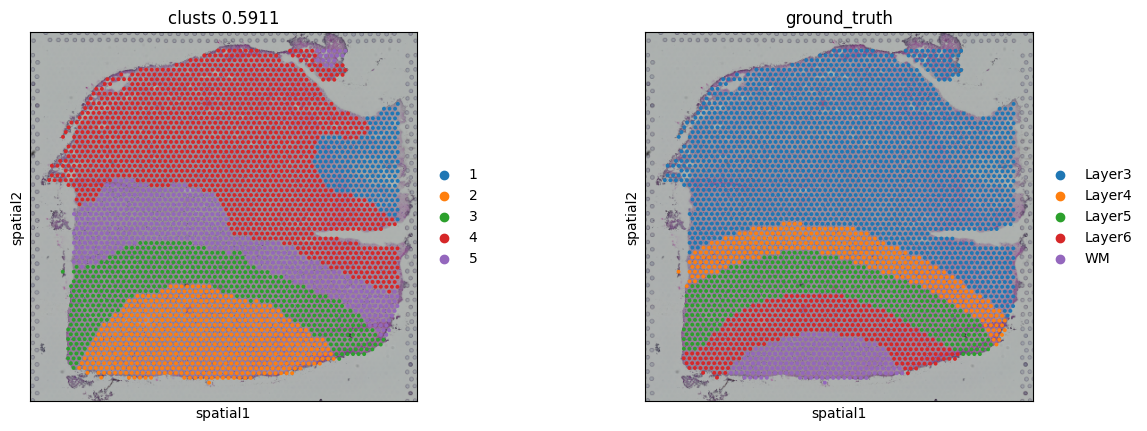

Dataset: 151670
ARI:  0.4311386771707045


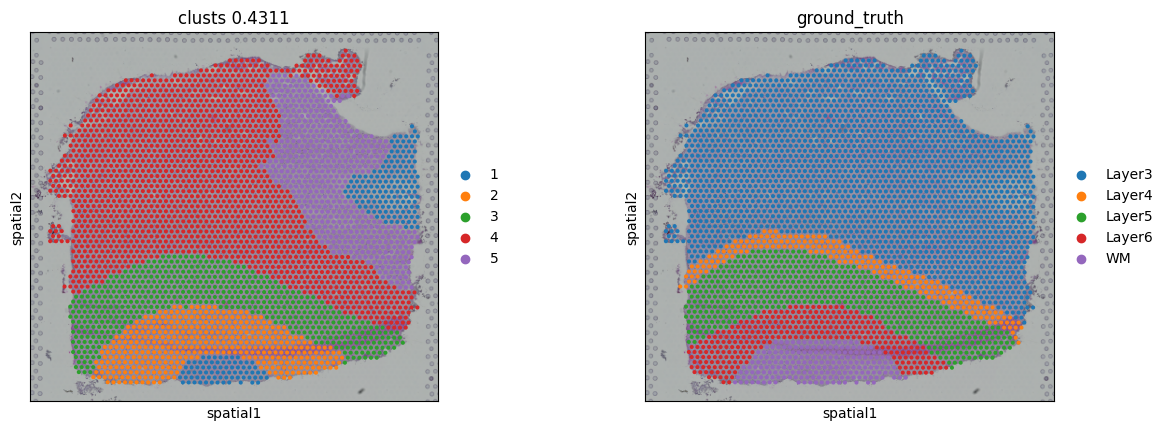

Dataset: 151671
ARI:  0.6132022557164084


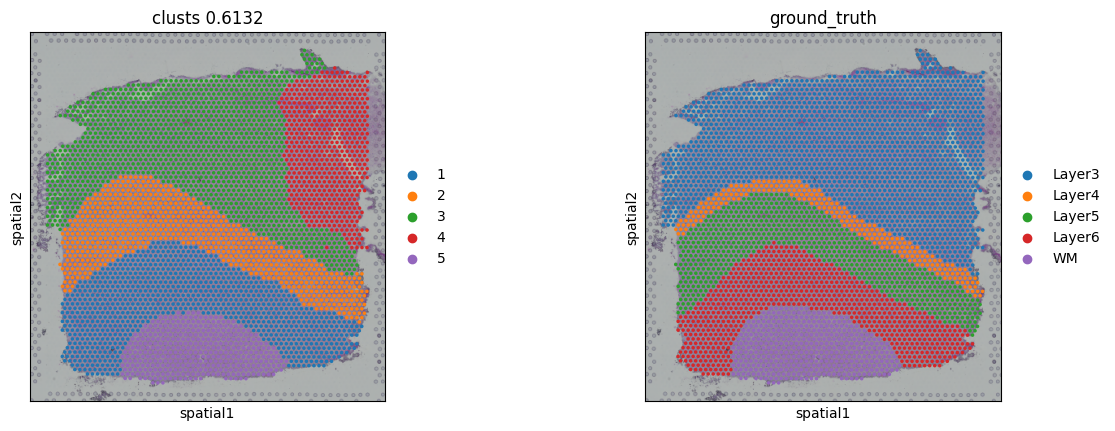

Dataset: 151672
ARI:  0.6324375888058408


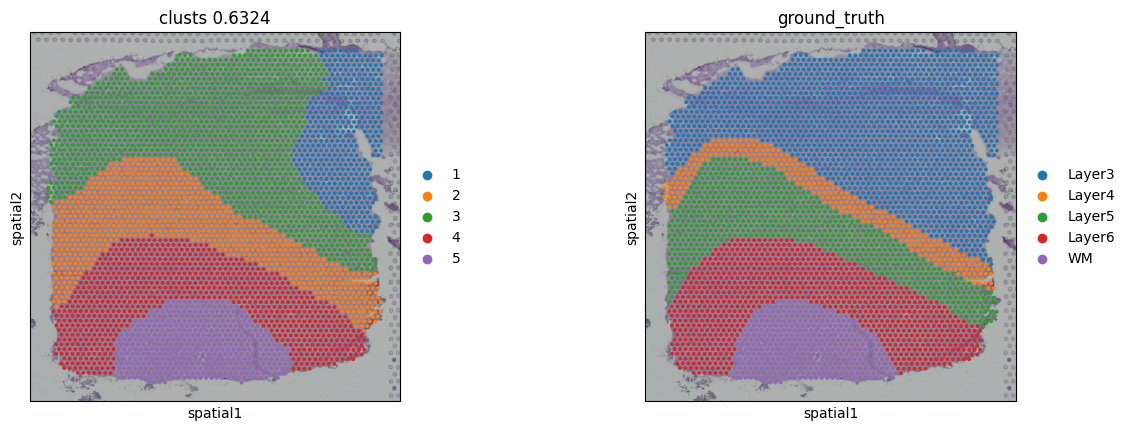

In [17]:
for dataset in datasets:
    adata_true[dataset] = adata_true[dataset][~pd.isnull(adata_true[dataset].obs['ground_truth'])]

    ARI = metrics.adjusted_rand_score(adata_true[dataset].obs['domain'], adata_true[dataset].obs['ground_truth'])
    adata_true[dataset].uns['ARI'] = ARI
    
    print('Dataset:', dataset)
    print('ARI: ', ARI)

    sc.pl.spatial(adata_true[dataset], img_key='lowres',color=['domain','ground_truth'], title=['clusts %.4f'%ARI, 'ground_truth'],show=True, 
              save=None)

<h3>GraphST + GSI</h3>

In [18]:
# separate test using our pipeline output reprocessed with GraphST (combined)
for dataset in datasets:
    beer_active_combine[dataset].var['highly_variable']= True
    
    model3 = GraphST.GraphST(beer_active_combine[dataset], device=device, dim_input=3609) #, dim_input=4015
    beer_active_combine[dataset] = model3.train()

Begin to train ST data...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:07<00:00, 79.94it/s]


Optimization finished for ST data!
Begin to train ST data...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:07<00:00, 84.03it/s]


Optimization finished for ST data!
Begin to train ST data...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:09<00:00, 63.51it/s]


Optimization finished for ST data!
Begin to train ST data...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:08<00:00, 69.97it/s]

Optimization finished for ST data!


In [19]:
for dataset in datasets:
    beer_active_combine[dataset] = beer_active_combine[dataset][~pd.isnull(beer_active_combine[dataset].obs['ground_truth'])]
    
    n_clusters = 5
        
    if tool == 'mclust':
       clustering(beer_active_combine[dataset], n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
    elif tool in ['leiden', 'louvain']:
       clustering(beer_active_combine[dataset], n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%


Dataset: 151669
ARI:  0.4225836544439376


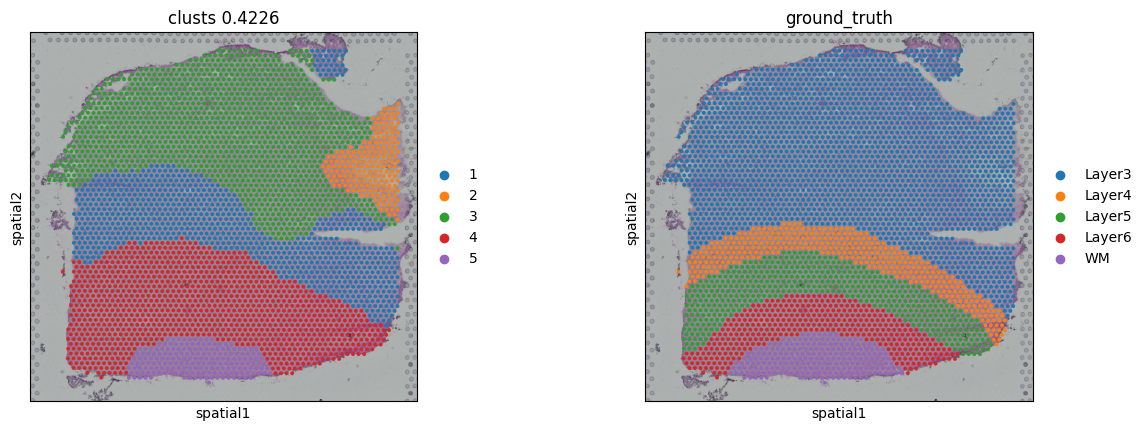

Dataset: 151670
ARI:  0.4564630344277398


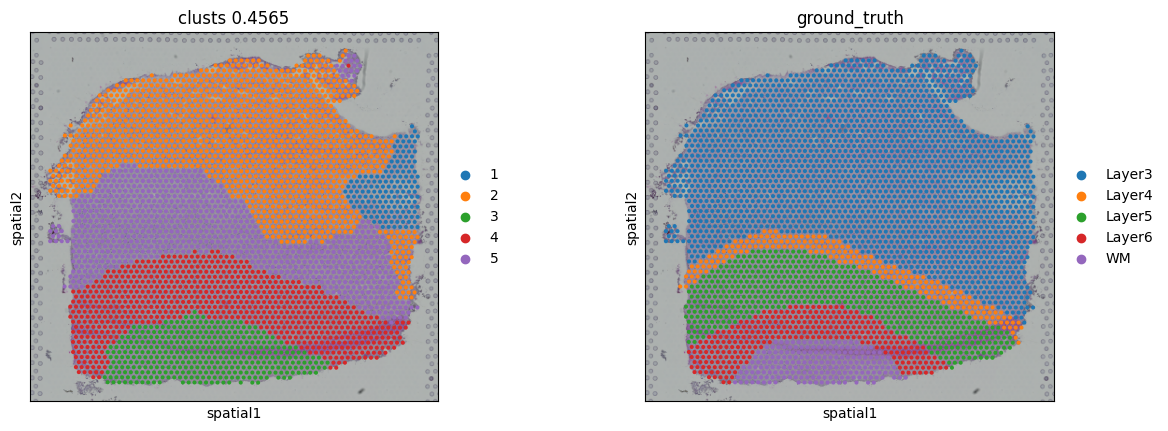

Dataset: 151671
ARI:  0.5560240053367481


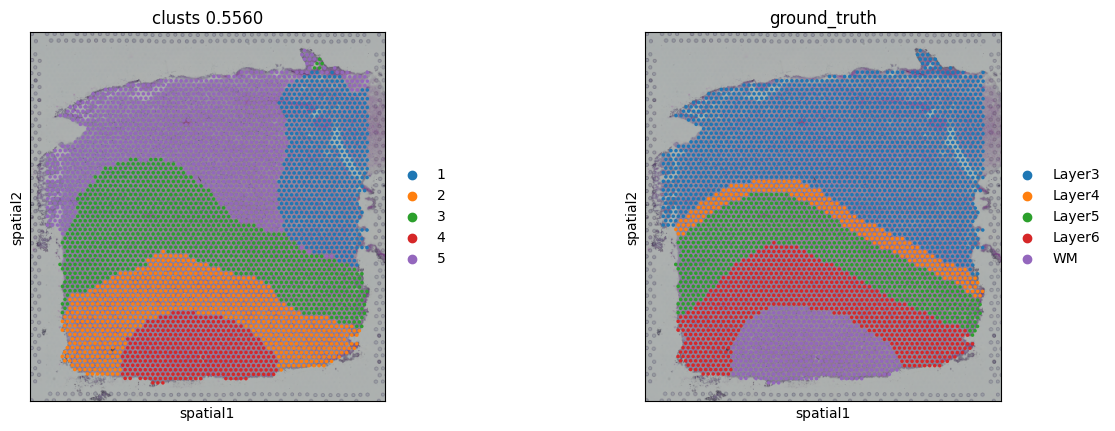

Dataset: 151672
ARI:  0.6516607395477553


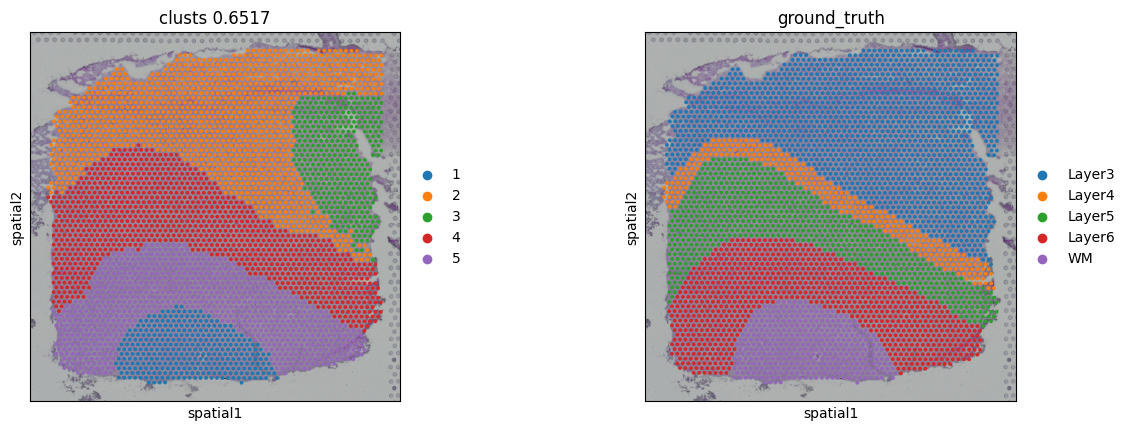

In [20]:
for dataset in datasets:
    
    ARI = metrics.adjusted_rand_score(beer_active_combine[dataset].obs['domain'], beer_active_combine[dataset].obs['ground_truth'])
    beer_active_combine[dataset].uns['ARI']=ARI
    
    print('Dataset:', dataset)
    print('ARI: ', ARI)

    sc.pl.spatial(beer_active_combine[dataset], img_key='lowres',color=['domain','ground_truth'], title=['clusts %.4f'%ARI, 'ground_truth'],show=True, 
             save=None) #'151673_combinedwbeer.png'
                                

---